In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import numpy as np
import pandas as pd

In [3]:
os.getcwd()

'/content'

In [4]:
TARGET_PATH = '/content/drive/MyDrive/Colab Notebooks/ball_data'

os.listdir(TARGET_PATH)

['football',
 'baseball',
 'tennis',
 'baseketball',
 'rugby',
 'volleyball',
 'golf']

In [9]:
dataset = []
for filepath in glob.iglob(f'{TARGET_PATH}/**/*.png', recursive=True):
  # print(filepath)
  ball_name = filepath.split('/')[6]
  dataset.append([filepath, ball_name])
dataset = np.array(dataset)
dataset.shape

(806, 2)

In [10]:
from sklearn.model_selection import train_test_split

train_image, test_image, train_target, test_target = train_test_split(dataset[:,0], dataset[:,1], stratify=dataset[:,1])

In [12]:
train_image.shape, train_target.shape

((604,), (604,))

In [14]:
test_image.shape, test_target.shape

((202,), (202,))

In [16]:
pd.Series(train_target).value_counts() / len(train_target)

tennis         0.165563
golf           0.160596
football       0.145695
volleyball     0.142384
baseball       0.137417
rugby          0.124172
baseketball    0.124172
dtype: float64

In [19]:
pd.Series(test_target).value_counts() / len(test_target)

tennis         0.168317
golf           0.158416
football       0.148515
volleyball     0.138614
baseball       0.138614
rugby          0.123762
baseketball    0.123762
dtype: float64

In [28]:
zip(train_image.tolist(), train_target.tolist())

In [23]:
import shutil

DATA_PATH = "dataset"
shutil.rmtree(DATA_PATH)

if not os.path.exists(DATA_PATH):
  os.mkdir(DATA_PATH)
  os.makedirs(os.path.join(DATA_PATH, 'train'))
  os.makedirs(os.path.join(DATA_PATH, 'test'))

  for ball_name in os.listdir(TARGET_PATH):
    os.makedirs(os.path.join(DATA_PATH, "train", ball_name))
    os.makedirs(os.path.join(DATA_PATH,"test",ball_name))

In [31]:
for filepath, target_dir in zip(train_image.tolist(), train_target.tolist()):
  filename = filepath.split('/')[-1]
  source_path = filepath
  target_dir = os.path.join(DATA_PATH, "train", target_dir, filename)
  shutil.copy(source_path, target_dir)

for filepath, target_dir in zip(test_image.tolist(), test_target.tolist()):
  filename = filepath.split('/')[-1]
  source_path = filepath
  target_dir = os.path.join(DATA_PATH, "test", target_dir, filename)
  shutil.copy(source_path, target_dir)

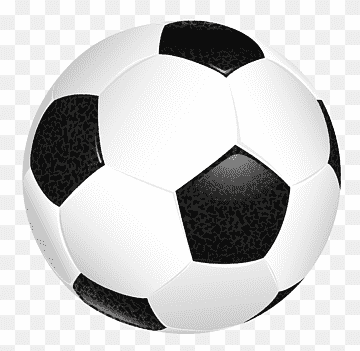

In [33]:
from PIL import Image

im = Image.open(target_dir)
im

/content/drive/MyDrive/Colab Notebooks/ball_data/baseball/baseball_num20.png
/content/drive/MyDrive/Colab Notebooks/ball_data/baseball/baseball_num50.png
/content/drive/MyDrive/Colab Notebooks/ball_data/baseball/baseball_num74.png
/content/drive/MyDrive/Colab Notebooks/ball_data/volleyball/volleyball_num35.png
/content/drive/MyDrive/Colab Notebooks/ball_data/baseball/baseball_num65.png
/content/drive/MyDrive/Colab Notebooks/ball_data/football/football_num118.png
/content/drive/MyDrive/Colab Notebooks/ball_data/football/football_num32.png
/content/drive/MyDrive/Colab Notebooks/ball_data/baseketball/baseketball_num87.png
/content/drive/MyDrive/Colab Notebooks/ball_data/baseketball/baseketball_num29.png
/content/drive/MyDrive/Colab Notebooks/ball_data/football/football_num35.png
['baseball' 'baseball' 'baseball' 'volleyball' 'baseball' 'football'
 'football' 'baseketball' 'baseketball' 'football']


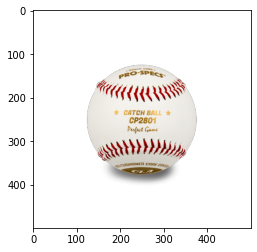

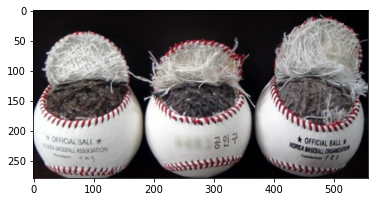

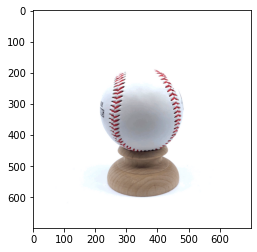

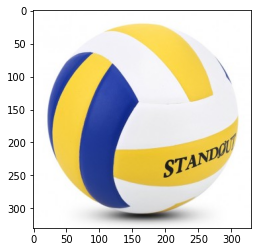

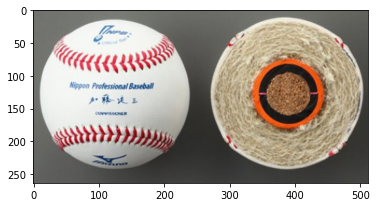

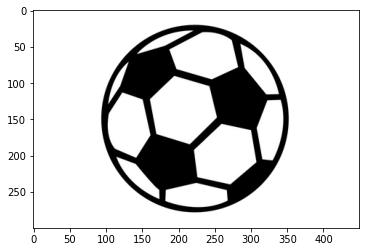

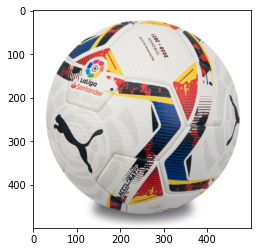

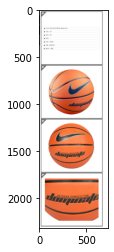

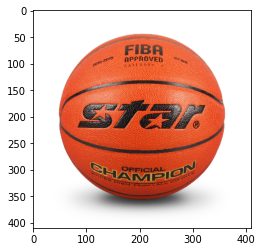

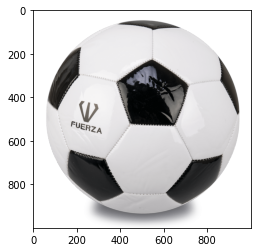

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def process(filename: str=None) -> None:
  image = mpimg.imread(filename)
  # <somthing gets done here>
  plt.figure()
  plt.imshow(image)

idx = np.random.choice(len(dataset), 10)
images = dataset[:, 0][idx]

for file in images:
  print(file)
  process(file)

print(dataset[:,1][idx])

In [37]:
from torchvision import datasets, transforms, models

# TODO : Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

DATASET_PATH = "dataset"

train_data = datasets.ImageFolder(DATASET_PATH + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(DATASET_PATH + '/test', transform=test_transforms)

In [38]:
train_data

Dataset ImageFolder
    Number of datapoints: 604
    Root location: dataset/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-30.0, 30.0], resample=False, expand=False)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [39]:
test_data

Dataset ImageFolder
    Number of datapoints: 202
    Root location: dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [40]:
import torch

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [63]:
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.autograd import Variable

def test_network(net, trainloader):
  
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(train_loader)
    images, lables = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimzer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):

    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1,2,0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


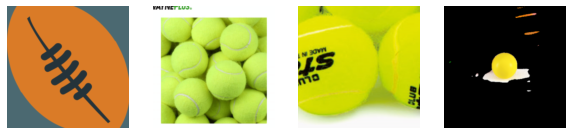

In [81]:
data_iter = iter(test_loader)

image, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(image[ii], ax=ax, normalize=True)